In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
folder_path = '../data'
datasets = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

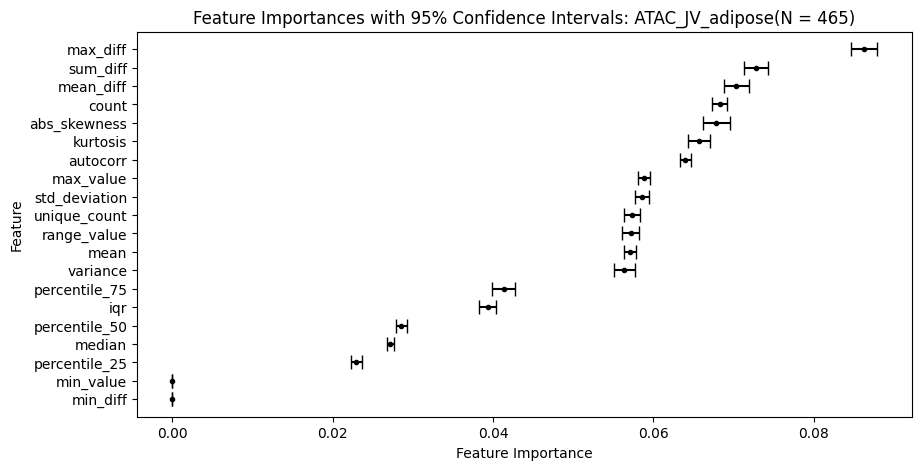

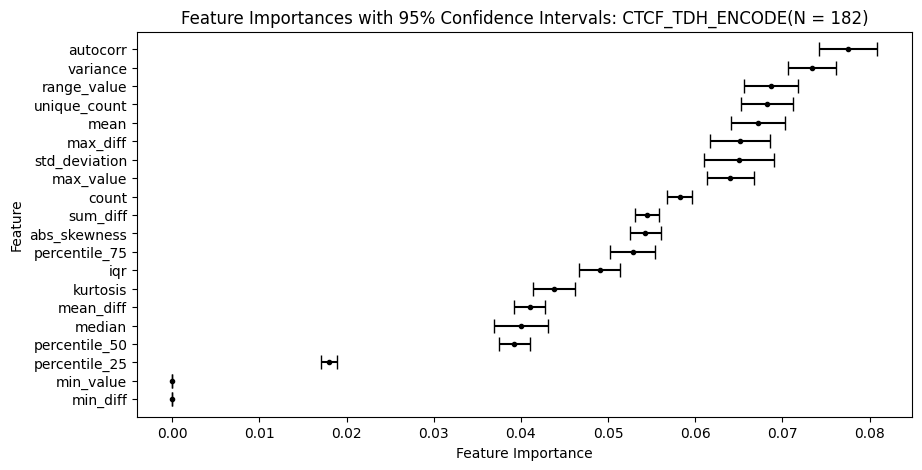

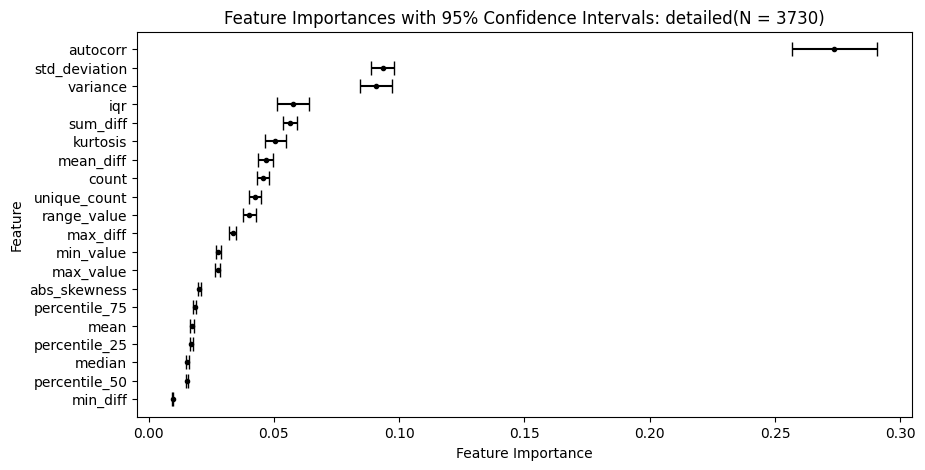

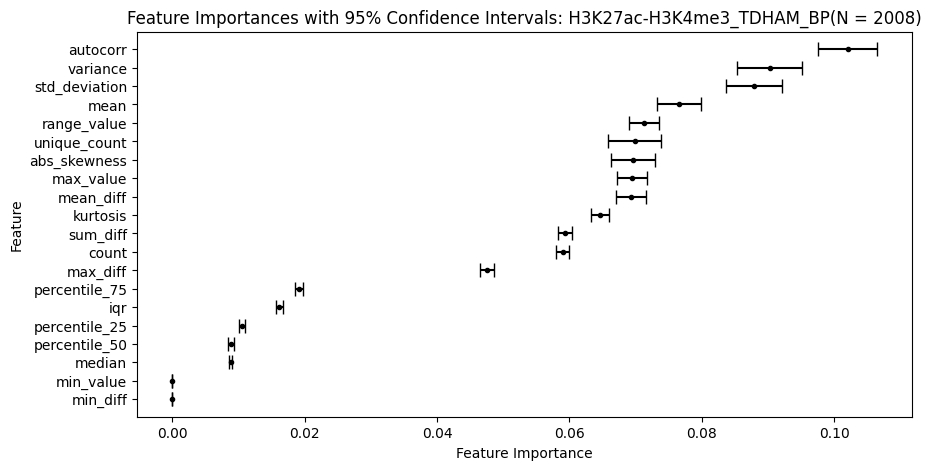

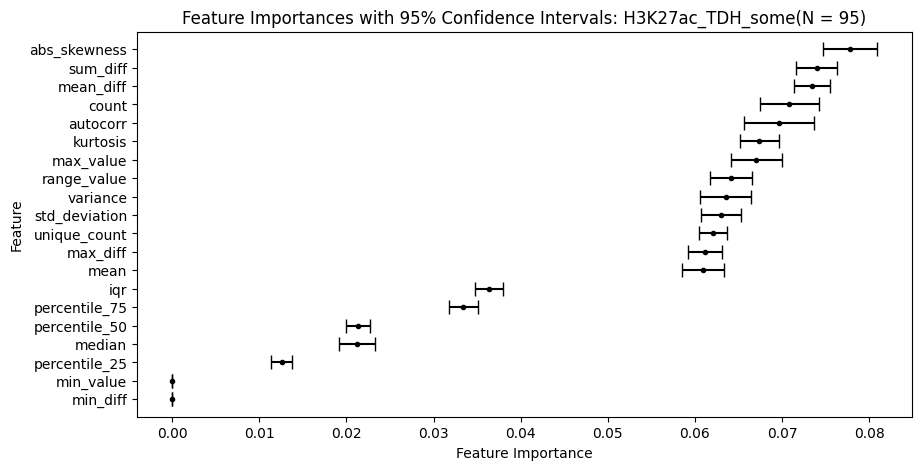

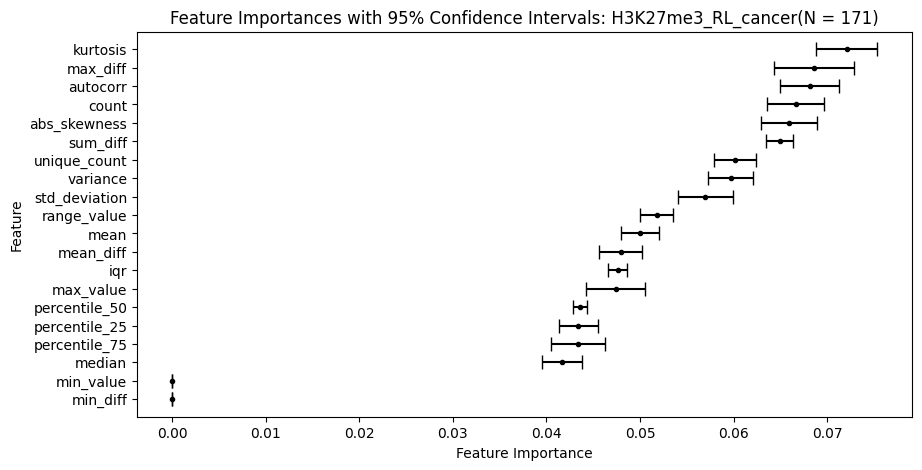

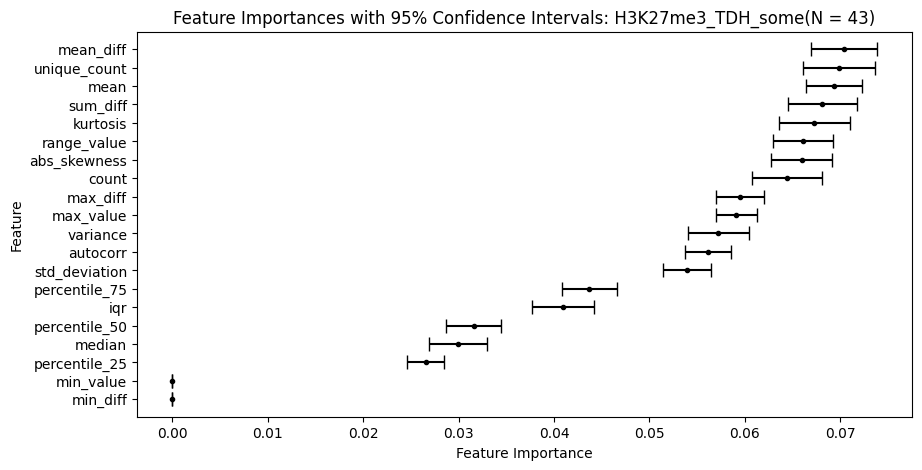

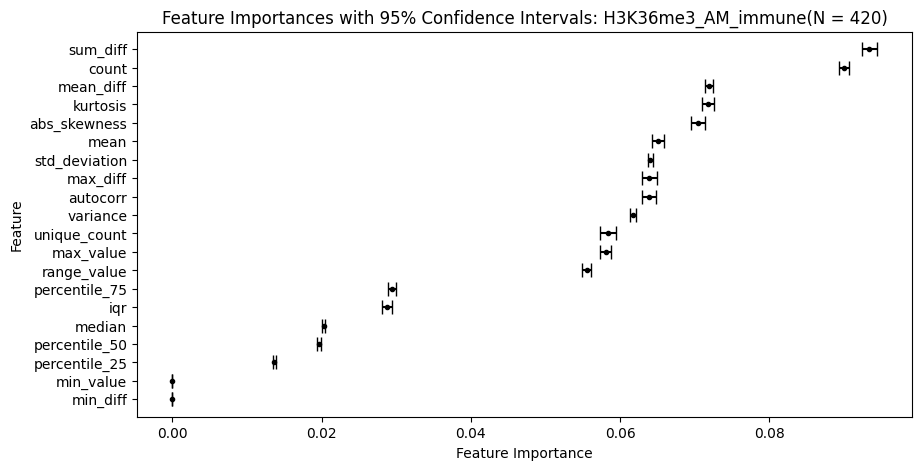

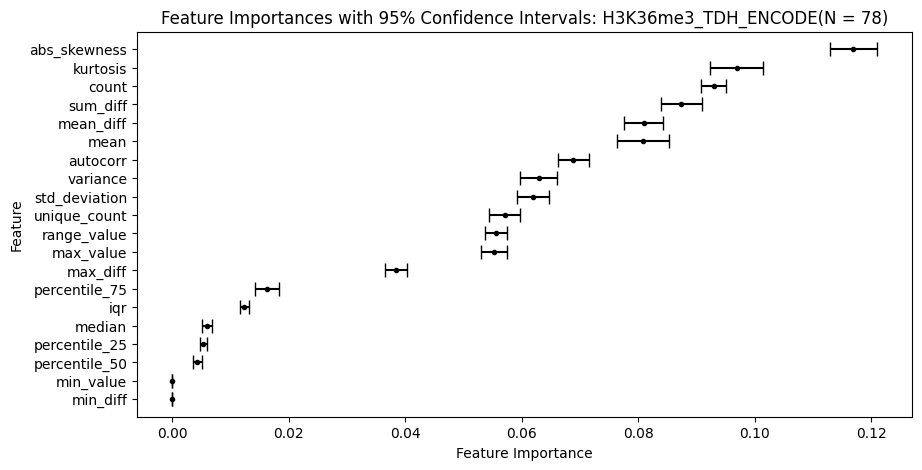

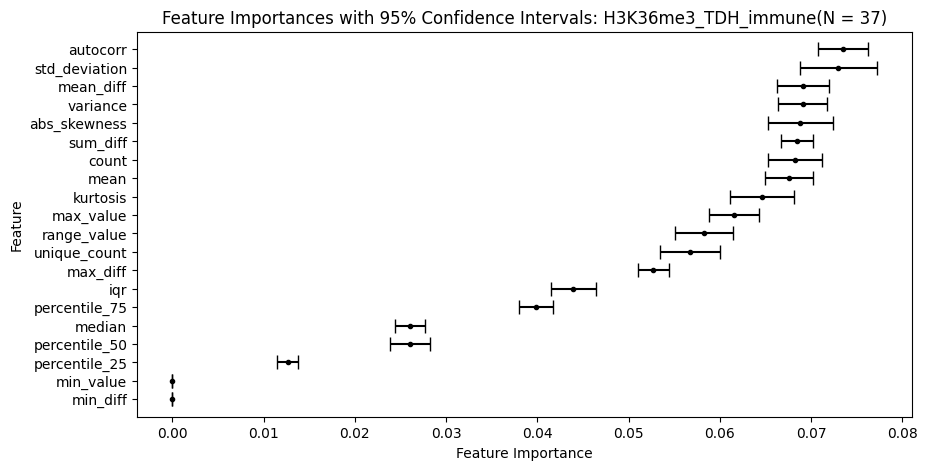

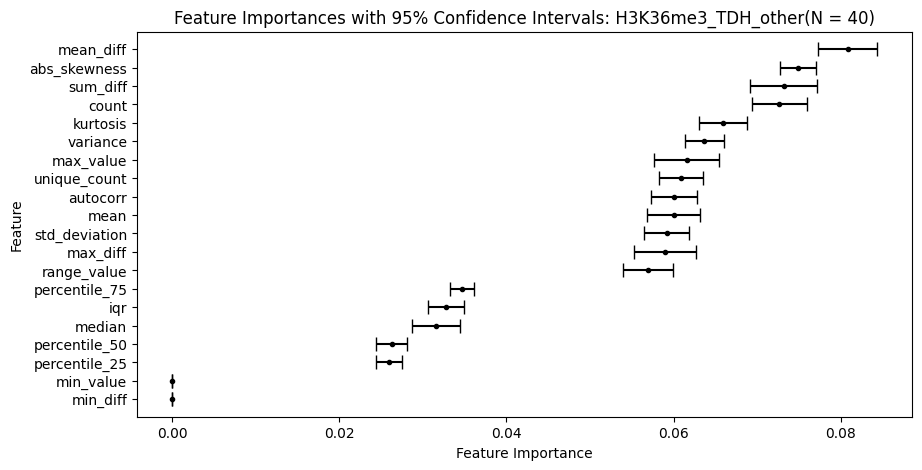

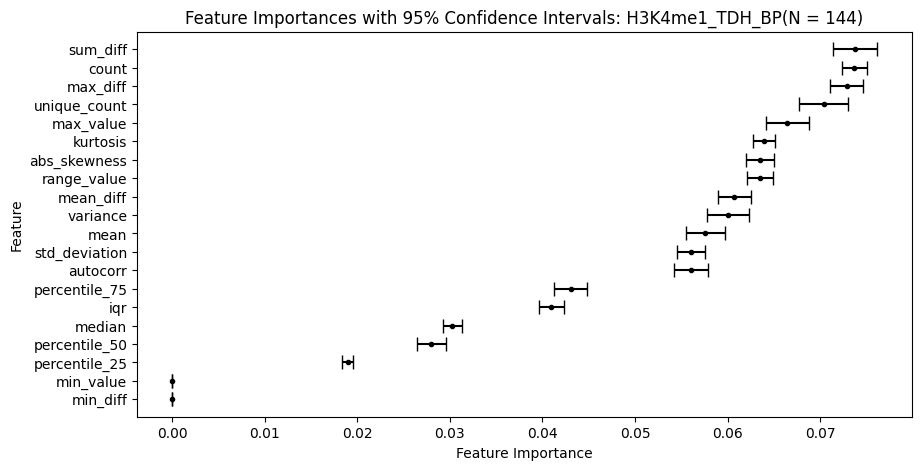

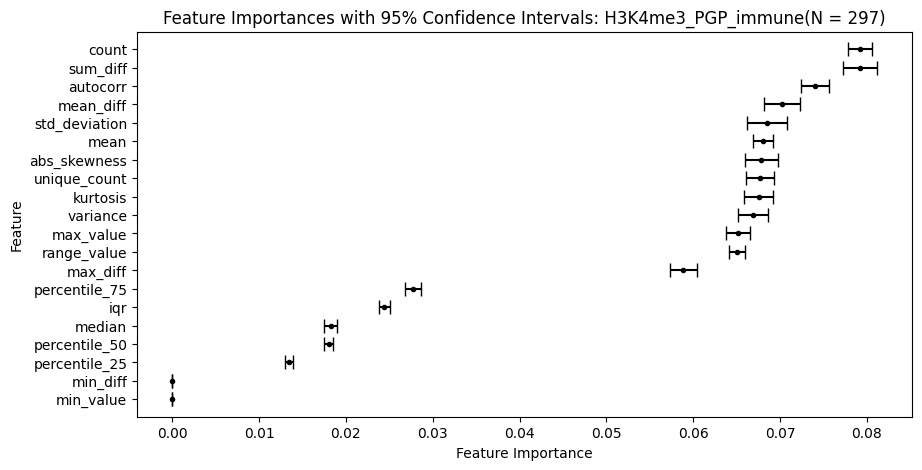

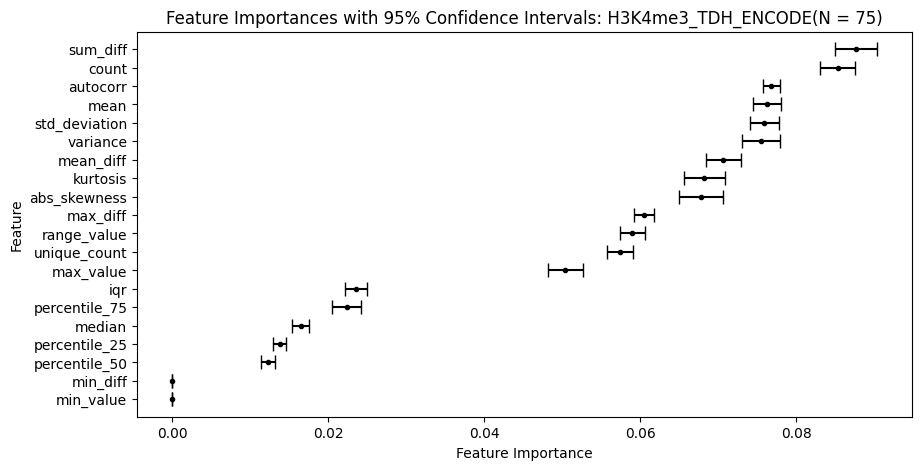

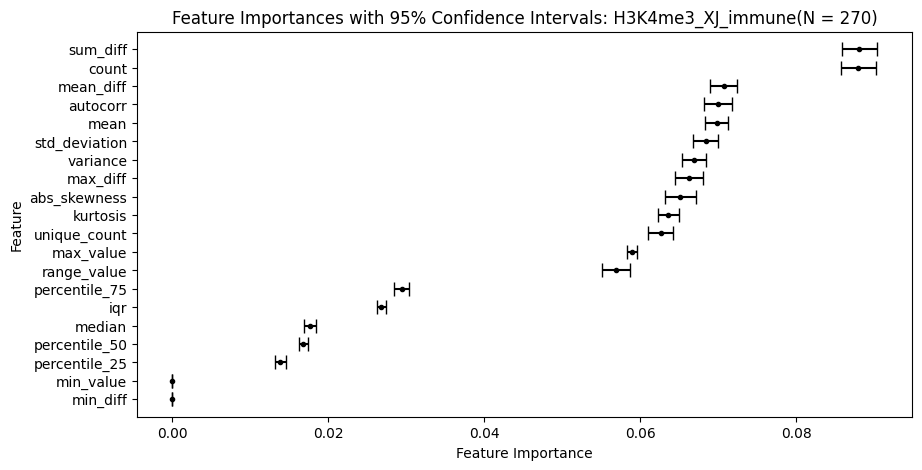

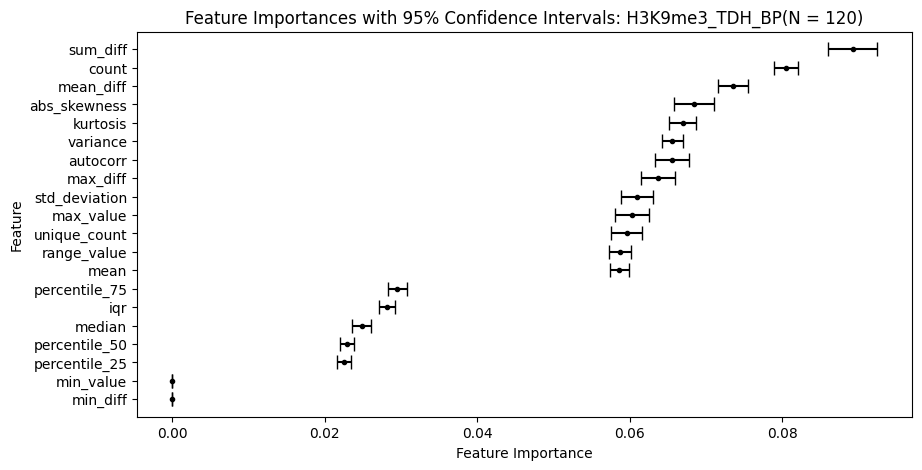

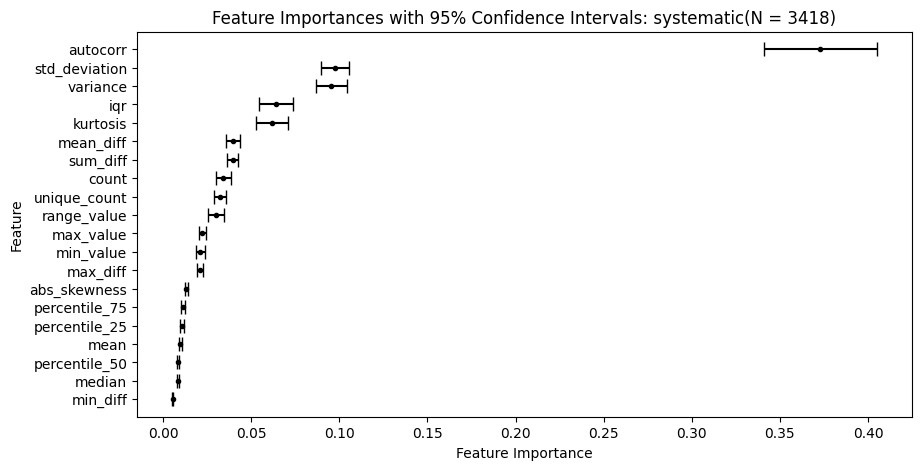

In [3]:
for dataset in datasets:
    feature_df = pd.read_csv('../data/' + dataset + '/features.csv').iloc[:, 1:21]
    target_df = pd.read_csv('../data/' + dataset + '/target.csv')

    class1_df = feature_df.copy()
    class1_df['log.lambda'] = target_df['min.log.lambda']

    class2_df = feature_df.copy()
    class2_df['log.lambda'] = target_df['max.log.lambda']

    # Remove rows where 'log.lambda' is infinity in both DataFrames
    class1_df = class1_df[~class1_df['log.lambda'].isin([float('inf'), -float('inf')])]
    class2_df = class2_df[~class2_df['log.lambda'].isin([float('inf'), -float('inf')])]

    # Add a 'label' column to each DataFrame to indicate the class
    class1_df['label'] = 0  # Label for class 1
    class2_df['label'] = 1  # Label for class 2

    # Concatenate the two DataFrames into one
    data_df = pd.concat([class1_df, class2_df], axis=0)

    # Separate the features (X) and the labels (y)
    X = data_df.drop('label', axis=1)  # Features
    y = data_df['label']  # Labels

    # Initialize parameters
    n_estimators = 10
    importances = np.zeros((n_estimators, X.shape[1] - 1))  # Store feature importances for each model

    for i in range(n_estimators):
        clf = RandomForestClassifier(n_estimators=100, random_state=i)
        clf.fit(X, y)
        importances[i] = clf.feature_importances_[:-1]  # Store importances, excluding the label column

    # Calculate mean and variance of feature importance
    mean_importances = np.mean(importances, axis=0)
    variance_importances = np.var(importances, axis=0)

    # Normalize the mean importances to sum to 1
    mean_importances /= np.sum(mean_importances)

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_df.columns,
        'Mean Importance': mean_importances,
        'Variance Importance': variance_importances
    })

    # Sort the DataFrame by Mean Importance
    importance_df = importance_df.sort_values(by='Mean Importance', ascending=True)

    # Create a scatter plot with error bars for variance
    plt.figure(figsize=(10, 5))
    plt.errorbar(importance_df['Mean Importance'], importance_df['Feature'], 
                xerr=np.sqrt(importance_df['Variance Importance']), fmt='o', capsize=5, color='black', markersize=3)
    plt.title('Feature Importances with 95% Confidence Intervals' + ": " + dataset + "(N = " + str(feature_df.shape[0]) + ")")
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.savefig("../figs/RF_Classification/" + dataset + ".png")
    plt.show()